<a href="https://colab.research.google.com/github/wenxuan0923/My-notes/blob/master/DL_multivariate_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate Time Series Forecasting
### - Temperature prediction

This note is an example of using LSTM model for multi-step multivariate time series prediction using Jena temperature data. The key topics being covered in this note are:

-  Convert multivariate time series data into DL dataset using self-defined generator
- LSTM model for multi-step prediction
- Why there are NaNs loss during training
- Why validation loss lower than training loss some time


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

The dataset used here is the same one in <a src='../dl_univariate_time_series' target='_blank'>this note</a>

In [2]:
temperature_df = pd.read_csv('jena_climate_2009_2016.csv')
temperature_df = temperature_df.set_index('Date Time')
temperature_df.index = pd.to_datetime(temperature_df.index, 
                                      format="%d.%m.%Y %H:%M:%S")
temperature_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### Prepare the data

To get the data ready for modelling, we need to:
* These 14 features have very different scales which need to be normalized independently 
* Convert the dataframe into a 2D tensor of shape (timesteps, features)
> This can be easily be done by using `df.values`
* Get ready a training and validation set


In [57]:
# Convert the dataframe into a 2D tensor
multi_ts = temperature_df.values
multi_ts

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

**Note:** `T (degC)` column is our target variable for this problem, which is the value at `index=1` for every list(row) in this np.array

We need to convert each sample into format: input (x) and an output (y). 

**Example 1**: To make **one-step** prediction using **past 3 days** data for univariate time series
```
 [1, 2, 3, 4, 5, 6, 7, 8, 9]
```

We want the data to be in the format:

[[1], [2], [3]] $\Rightarrow$ 5 <br>
[[2], [3], [4]] $\Rightarrow$ 6 <br>
[[3], [4], [5]] $\Rightarrow$ 7 <br>
[[4], [5], [6]] $\Rightarrow$ 8 <br>
$\vdots$ 

In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

Thus, to make **two-step** prediction using **past 3 days** data for the same time series, the data will be in the format:

[[1], [2], [3]] $\Rightarrow$ [5, 6] <br>
[[2], [3], [4]] $\Rightarrow$ [6, 7] <br>
[[3], [4], [5]] $\Rightarrow$ [7, 8] <br>
[[4], [5], [6]] $\Rightarrow$ [8, 9] <br>
$\vdots$ 

Illustration for this example:

<center><img src='https://drive.google.com/uc?id=1LFkGPk8iwLY6ZsOCP8eWoaTej4iKXuHP' width=600></img></center>



**Example 2**: you have time series:

```
 [[1, 2, 2], [3, 12, 4], [5, 30, 6], [7, 56, 8], [9, 90, 10], [11, 132, 12]]
```
The second value of each list (values [2, 12, 30, 56, 90, 132]) is the target value (with index 1). 

To make **one-step** prediction using **past 2 days** data for multivariate time series, we need the data to be in the format:

 [[1, 2, 2], [3, 12, 4]] $\Rightarrow$ 56 <br>
 [[3, 12, 4], [5, 30, 6]] $\Rightarrow$ 90 <br>
 [[5, 30, 6], [7, 56, 8]] $\Rightarrow$ 132 <br>

Similarly, to make **two-step** prediction using **past 2 days** data for the same time series, we want the data to be in the format:

We want the data to be in the format:

 [[1, 2, 2], [3, 12, 4]]  $\Rightarrow$ [56, 90]<br>
 [[3, 12, 4], [5, 30, 6]] $\Rightarrow$ [90, 132] <br>

To get the data in this format, we define a generator function:




In [0]:
def generator(data, look_back, pred_step, min_index, max_index,
              shuffle=False, batch_size=1, step=1):
    if max_index is None:
        max_index = len(data) - pred_step 

    # i represents each batch
    i = min_index + look_back
    while True:
        if shuffle:
            rows = np.random.randint(
                    min_index + look_back, max_index, size=batch_size)
        else:
            if i + batch_size > max_index:
                i = min_index + look_back    # start over
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),  # number of samples in each batch
                            look_back // step,  # number of time steps in each sample  
                            data.shape[-1]))  # number of features in each sample  

        targets = np.zeros((len(rows), pred_step//step)) if pred_step > 1 \
                                                     else np.zeros((len(rows)))

        # j represents each sample
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_back, rows[j], step) # note rows[j] is not included
            samples[j] = data[indices]
            if pred_step > 1:
                targets[j] = [dt[1] for dt in 
                              data[(rows[j]+1):(rows[j] + pred_step + 1):step]]
            else:
                targets[j] = data[rows[j] + pred_step][1]
    
        yield samples, targets

Note: in `range()` and `lst[:]` the right limit is not included.
 

- **data**: The original array of floating-point data of shape (timesteps, features)
- **look_back**: How many timesteps back the input data should go
- **pred_step**: How many timesteps in the future the target should be
- **min_index** and **max_index**: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- **shuffle**: Whether to shuffle the samples or draw them in chronological order
- **batch_size**: The number of samples per batch
- **step**: The period, in timesteps, at which you sample data. 

**This function can be illustrated by the image below:**

<center><img src='https://drive.google.com/uc?id=1SCd0rbpJL4DQL871mZf2BVLwAhW5TJDu' width=500></img></center>

At index t:
- input data is: $[x_{(t-\text{look_back})},...,x_{t-2},x_{t-1}]$
- output target is: $[x_{(t+\text{pred_step})}]$






#### Unit test:

In [5]:
example_ts = np.array([[1, 2, 2], [3, 12, 4], 
                       [5, 30, 6], [7, 56, 8], 
                       [9, 90, 10], [11, 132, 12]])
example_ts = example_ts.reshape(-1, 3)   # multivariate data with 3 features
example_gen = generator(example_ts, look_back=2, pred_step=1, 
                        min_index=0, max_index=None)
i = 0
while i <= 3:
  display(next(example_gen))
  i += 1

(array([[[ 1.,  2.,  2.],
         [ 3., 12.,  4.]]]), array([56.]))

(array([[[ 3., 12.,  4.],
         [ 5., 30.,  6.]]]), array([90.]))

(array([[[ 5., 30.,  6.],
         [ 7., 56.,  8.]]]), array([132.]))

(array([[[ 1.,  2.,  2.],
         [ 3., 12.,  4.]]]), array([56.]))

In [6]:
example_gen = generator(example_ts, look_back=2, pred_step=2, 
                        min_index=0, max_index=None)
i = 0
while i <= 3:
  display(next(example_gen))
  
  i += 1

(array([[[ 1.,  2.,  2.],
         [ 3., 12.,  4.]]]), array([[56., 90.]]))

(array([[[ 3., 12.,  4.],
         [ 5., 30.,  6.]]]), array([[ 90., 132.]]))

(array([[[ 1.,  2.,  2.],
         [ 3., 12.,  4.]]]), array([[56., 90.]]))

(array([[[ 3., 12.,  4.],
         [ 5., 30.,  6.]]]), array([[ 90., 132.]]))

#### Normalize data

In [31]:
multi_ts = temperature_df.values
TRAIN_SPLIT = 300000 
# Only use the training data for normalization
multi_train_mean = multi_ts[:TRAIN_SPLIT].mean()
multi_train_std = multi_ts[:TRAIN_SPLIT].std()
multi_data = (multi_ts-multi_train_mean)/multi_train_std
multi_data

array([[ 2.09495432, -0.54712107,  0.17201033, ..., -0.52331835,
        -0.52142465, -0.12545789],
       [ 2.09508583, -0.54814682,  0.17098458, ..., -0.52413369,
        -0.52208219, -0.16806607],
       [ 2.09498063, -0.54840984,  0.17072156, ..., -0.52552766,
        -0.52437041, -0.0746963 ],
       ...,
       [ 2.10363377, -0.53433862,  0.18413525, ..., -0.52318685,
        -0.52076712,  0.03997757],
       [ 2.10360747, -0.53715286,  0.181321  , ..., -0.52210849,
        -0.5203463 ,  0.067857  ],
       [ 2.10363377, -0.53870464,  0.17979553, ..., -0.52279232,
        -0.52087233, -0.03971551]])

In this note, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour (step=6). Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [0]:
look_back = 720 
pred_step = 72   
STEP = 6          
BATCH_SIZE = 256

train_gen = generator(multi_data, 
                      look_back, 
                      pred_step, 
                      min_index=0, 
                      max_index=TRAIN_SPLIT,
                      shuffle=True,
                      step=STEP,
                      batch_size=BATCH_SIZE)

val_gen = generator(multi_data, 
                    look_back, 
                    pred_step, 
                    min_index=TRAIN_SPLIT+1,
                    max_index=None,
                    step=STEP,
                    batch_size=BATCH_SIZE)

Let's take a look at a single data point in your training set:

In [33]:
# Each batch has 256 data points
first_train_data = next(train_gen) 
print(len(first_train_data[0]))  # input data x
print(len(first_train_data[1]))  # target value y

256
256


In [34]:
# Shape for the first sample (index 0)
print(first_train_data[0][0].shape)
print(first_train_data[1][0].shape)

(120, 14)
(12,)


### Visulize input & target value

Let's plot the historical & target temperature value for this first data point: look back 5 days (120 hours) an predict 12 hours into the future.


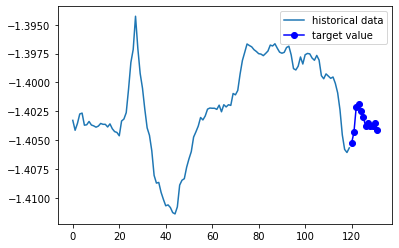

In [12]:
x_train_first = [dt[1] for dt in first_train_data[0][0]] # Only check the target vlue
y_train_first = first_train_data[1][0]
plt.plot(range(len(x_train_first)), x_train_first, label='historical data')
plt.plot(range(len(x_train_first), len(x_train_first) + int(pred_step/STEP)), y_train_first,
         color='blue', marker='o', label='target value')
plt.legend()
plt.show()

### A LSTM model for time series forecast
Since the task here is a bit complicated, 
the model consists of two LSTM layers. Besides, since 12 predictions are made, the final dense layer has 12 units (outputs 12 predictions).

In [38]:
model = Sequential()

model.add(LSTM(32, dropout=0.1, 
              input_shape=(120, 14)))
model.add(layers.BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(layers.BatchNormalization())

model.add(Dense(12))  

model.compile(optimizer=RMSprop(lr=0.001, clipnorm=1), loss='mae')
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 32)                6016      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_14 (Batc (None, 16)                64        
_________________________________________________________________
dense_14 (Dense)             (None, 12)                204       
Total params: 6,940
Trainable params: 6,844
Non-trainable params: 96
_________________________________________________________________


In [0]:
call_backs = [EarlyStopping(monitor='val_loss',
                            patience=5),
              ModelCheckpoint(filepath='multi_ts_pred.h5', 
                              monitor='val_loss',
                              save_best_only=True)]

In [40]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    steps_per_epoch=(TRAIN_SPLIT-look_back)//BATCH_SIZE,
    validation_data=val_gen,
    callbacks=call_backs,
    validation_steps=(len(multi_data)-TRAIN_SPLIT-look_back)//BATCH_SIZE
)

Epoch 1/20
1169/1169 [==============================] - 207s 177ms/step - loss: 0.0574 - val_loss: 0.0239
Epoch 2/20
1169/1169 [==============================] - 214s 183ms/step - loss: 0.0117 - val_loss: 0.0247
Epoch 3/20
1169/1169 [==============================] - 208s 178ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 4/20
1169/1169 [==============================] - 207s 177ms/step - loss: 0.0095 - val_loss: 0.0193
Epoch 5/20
1169/1169 [==============================] - 205s 175ms/step - loss: 0.0094 - val_loss: 0.0182
Epoch 6/20
1169/1169 [==============================] - 204s 174ms/step - loss: 0.0092 - val_loss: 0.0132
Epoch 7/20
1169/1169 [==============================] - 203s 174ms/step - loss: 0.0087 - val_loss: 0.0100
Epoch 8/20
1169/1169 [==============================] - 205s 176ms/step - loss: 0.0084 - val_loss: 0.0122
Epoch 9/20
1169/1169 [==============================] - 203s 174ms/step - loss: 0.0082 - val_loss: 0.0221
Epoch 10/20
1169/1169 [=======================

**There might be `nan` loss during the training of this model, this is because:**

> Regression with neural networks is hard to get working because the output is unbounded, so you are especially prone to the exploding gradients problem (the likely cause of the nan loss). Historically, one key solution to exploding gradients was to reduce the learning rate, but with the advent of per-parameter adaptive learning rate algorithms like Adam, you no longer need to set a learning rate to get good performance. There is very little reason to use SGD with momentum anymore unless you're a neural network fiend and know how to tune the learning schedule.

**Here are some things you could potentially try:**

- Normalize the outputs by quantile normalizing or z scoring. To be rigorous, compute this transformation on the training data, not on the entire dataset. For example, with quantile normalization, if an example is in the 60th percentile of the training set, it gets a value of 0.6. (You can also shift the quantile normalized values down by 0.5 so that the 0th percentile is -0.5 and the 100th percentile is +0.5)

- Add regularization, either by increasing the dropout rate or adding L1 and L2 penalties to the weights. 

- Reduce the size of the network. This is not always the best idea since it can harm performance.

- Increase the batch size could potentially increase the stability of the optimization.

**Besies, you may find validation loss is lower than training loss which is counter-intuitive, this might because**:

When dropout regularization is being used in the network, it is reasonable that the validation error is smaller than training error. Because usually dropout is activated when training but deactivated when evaluating on the validation set. You get a more smooth (usually means better) function in the latter case.

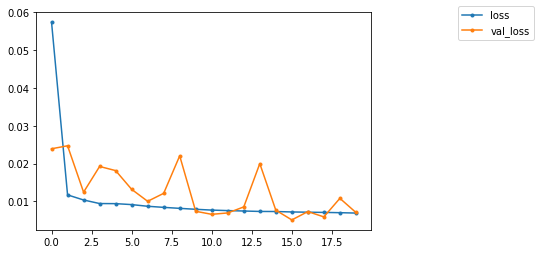

In [41]:
ax = pd.DataFrame(history.history)[['loss', 'val_loss']].plot(marker='.')
ax.legend(bbox_to_anchor=(1.5, 1.05))
plt.show()

### Visualize prediction result

In [0]:
best_model = load_model('multi_ts_pred.h5')

In [0]:
def plot_pred_target(x, y, pred_step, step):
    x_train_first = [dt[1] for dt in x] # Only check the target vlue
    y_train_first = y
    plt.plot(range(len(x_train_first)), x_train_first, label='historical data')
    plt.plot(range(len(x_train_first)+1, len(x_train_first)+1 + int(pred_step/step)), 
            y_train_first, color='blue', marker='o', label='target value')
    plt.plot(range(len(x_train_first)+1, len(x_train_first)+1 + int(pred_step/step)), 
            best_model.predict(x.reshape(1, 120, 14))[0],
            color='red', marker='o', label='predicted value')
    plt.legend()
    plt.show()
    return 

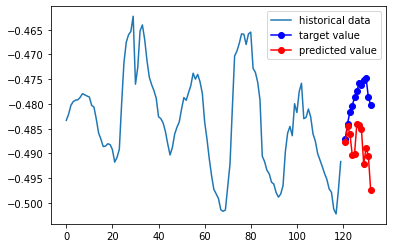

In [70]:
x = first_train_data[0][0]
y = first_train_data[1][0]
plot_pred_target(x, y, pred_step, STEP)

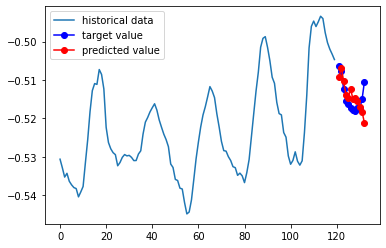

In [71]:
x = first_train_data[0][22]
y = first_train_data[1][22]
plot_pred_target(x, y, pred_step, STEP)

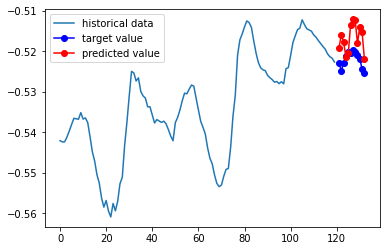

In [72]:
x = first_train_data[0][4]
y = first_train_data[1][4]
plot_pred_target(x, y, pred_step, STEP)

Useful Reference:

1. [TensorFlow tutorial: Time Series Forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

2. [Machinelearningmastery: How to Use the TimeseriesGenerator for Time Series Forecasting in Keras](
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/)

3. [Stackoverflow: steps_per_epoch v.s. validation_steps](https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list)